In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Aniljha@2802',
    database='ecommerce'
)
cursor= conn.cursor()


# list all unique cities where customers are located.

In [13]:
query= """ select distinct customer_city from customers """

cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data, columns = ["Cities" ])
df

,Cities
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


# Count the number of orders placed in 2017.

In [15]:
query= """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)
data= cur.fetchall()
"Total orders placed in 2017 are" ,data[0][0]

('Total orders placed in 2017 are', 90202)

# Count the number of orders placed in 2018.

In [17]:
query= """ select count(order_id) from orders where year(order_purchase_timestamp) = 2018 """

cur.execute(query)
data= cur.fetchall()
"Total orders placed in 2018 are" ,data[0][0]

('Total orders placed in 2018 are', 108022)

# Find the total sales per category.

In [19]:
query= """ select products.product_category category, 
round(sum(payments.payment_value),2) sales
from products join items_order
on products.product_id = items_order.product_id
join payments
on payments.order_id= items_order.order_id
group by category
"""
cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data, columns = ["Category" , "Sales" ])
df

,Category,Sales
0,perfumery,4053909.28
1,Furniture Decoration,11441411.12
2,telephony,3895056.40
3,bed table bath,13700429.36
4,automotive,6818354.64
...,...,...
69,cds music dvds,9595.44
70,La Cuisine,23308.24
71,Fashion Children's Clothing,6285.36
72,PC Gamer,17395.44


# Calculate the percentage of orders that were paid in installments.

In [14]:
query= """ select (sum(case when payment_installments >= 1 then 1
else 0 end))/count(*)*100 from payments
"""

cur.execute(query)
data= cur.fetchall()
data   

[(Decimal('99.9981'),)]

# Count the number of customers from each state.

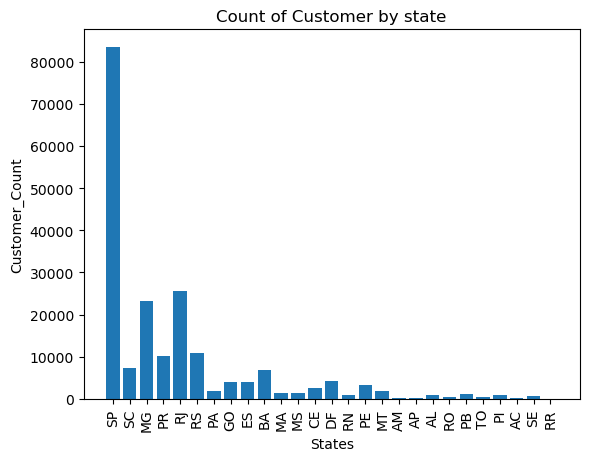

In [20]:
query= """ select customer_state,count(customer_id)
from customers group by customer_state
"""

cur.execute(query)
data= cur.fetchall()
df= pd.DataFrame(data, columns= ["State", "Customer_Count"])
plt.bar(df["State"], df["Customer_Count"])
plt.xticks(rotation = 90)
plt.xlabel("States")
plt.ylabel("Customer_Count")
plt.title("Count of Customer by state")
plt.show()

# Calculate the number of orders per month in 2018

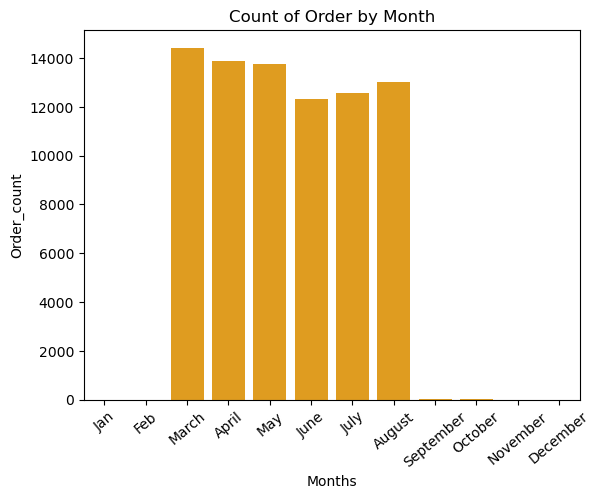

In [21]:
query= """ select monthname(order_purchase_timestamp) Months ,
count(order_id) Order_count from orders where year(order_purchase_timestamp)=2018
group by months"""

cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data, columns = ["Months", "Order_count"])
o= ["Jan", "Feb", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
sns.barplot(x=df["Months"], y=df["Order_count"],data=df, order= o,color="Orange")
plt.xticks(rotation=40)
plt.title("Count of Order by Month")
plt.show()

# Find the average number of Products per order grouped by Customer city

In [25]:
query= """ with count_per_order as
(select orders.order_id, orders.customer_id,count(items_order.order_item_id) as oc
from orders join items_order
on orders.order_id = items_order.order_id
group by orders.order_id, orders.customer_id)
select customers.customer_city, round(avg(count_per_order.oc))average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
""" 
cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data, columns=["customer_city" , "average_orders"])
df.head(10)

,customer_city,average_orders
0,padre carvalho,28
1,celso ramos,26
2,datas,24
3,candido godoi,24
4,matias olimpio,20
5,cidelandia,16
6,curralinho,16
7,picarra,16
8,morro de sao paulo,16
9,teixeira soares,16


# Calculate the percentage of total revenue contributed by each product category.

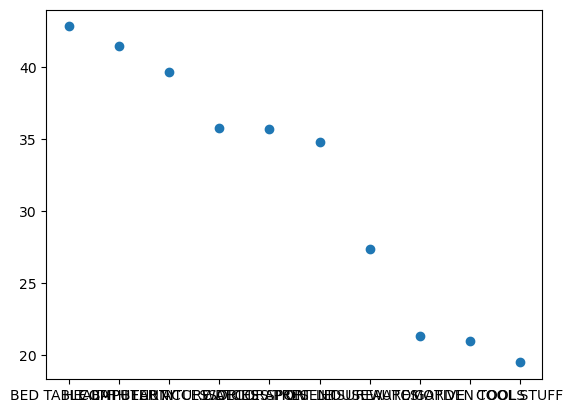

<Figure size 1000x500 with 0 Axes>

In [54]:
query= """select upper(products.product_category) category, 
round(sum(payments.payment_value)/(select sum(payment_value) from payments)* 100,2)  
sales_percentage
from products join items_order
on products.product_id = items_order.product_id
join payments
on payments.order_id= items_order.order_id
group by category order by sales_percentage desc;
"""
cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data, columns = ["Category" , "Sales_Percentage" ])
df=df.head(10)
plt.scatter(df["Category"], df["Sales_Percentage"])
plt.figure(figsize=(10,5))
plt.show()

# Identify the correlation between product price and the number of times a product can be purchased 

In [30]:
query= """select upper(products.product_category), 
count(items_order.product_id),
round(avg(items_order.price),2)
from products join items_order
on products.product_id = items_order.product_id
group by products.product_category
"""
cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data, columns = ["Category" , "order_count","price"])

arr1=df["order_count"]
arr2=df["price"]

a=np.corrcoef([arr1,arr2])
print("The correlation is ",a[0][-1])

The correlation is  -0.10631514167157562


# Calculate total revenue generated by each seller, and rank them by revenue

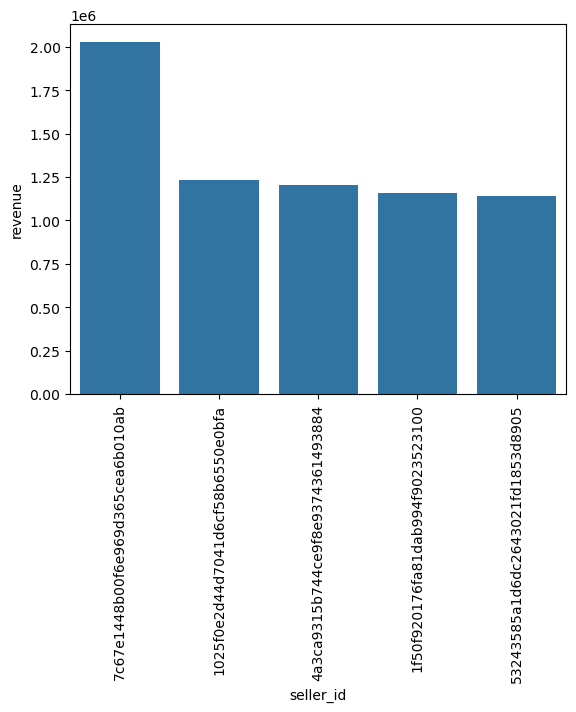

In [48]:
query= """ select *, dense_rank() over(order by revenue desc) as rn from
(select items_order.seller_id ,sum(payments.payment_value) revenue
from items_order join payments
on items_order.order_id = payments.order_id
group by items_order.seller_id) as a
"""
cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data, columns=["seller_id","revenue", "rank"])
df=df.head()
sns.barplot(x="seller_id", y="revenue",data=df)
plt.xticks(rotation=90)
plt.show()

# Calculate the moving average of order values from each customer over their order history

In [34]:
query="""select customer_id, order_purchase_timestamp,payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as moving_avg
from 
(select orders.customer_id,orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a
"""
cur.execute(query)
data= cur.fetchall()
data

[('00012a2ce6f8dcda20d059ce98491703', '2017-11-14 16:08:26', '114.74', 114.74),
 ('00012a2ce6f8dcda20d059ce98491703', '2017-11-14 16:08:26', '114.74', 114.74),
 ('00012a2ce6f8dcda20d059ce98491703', '2017-11-14 16:08:26', '114.74', 114.74),
 ('00012a2ce6f8dcda20d059ce98491703', '2017-11-14 16:08:26', '114.74', 114.74),
 ('000161a058600d5901f007fab4c27140', '2017-07-16 09:40:32', '67.41', 67.41),
 ('000161a058600d5901f007fab4c27140', '2017-07-16 09:40:32', '67.41', 67.41),
 ('000161a058600d5901f007fab4c27140', '2017-07-16 09:40:32', '67.41', 67.41),
 ('000161a058600d5901f007fab4c27140', '2017-07-16 09:40:32', '67.41', 67.41),
 ('0001fd6190edaaf884bcaf3d49edf079', '2017-02-28 11:06:43', '195.42', 195.42),
 ('0001fd6190edaaf884bcaf3d49edf079', '2017-02-28 11:06:43', '195.42', 195.42),
 ('0001fd6190edaaf884bcaf3d49edf079', '2017-02-28 11:06:43', '195.42', 195.42),
 ('0001fd6190edaaf884bcaf3d49edf079', '2017-02-28 11:06:43', '195.42', 195.42),
 ('0002414f95344307404f0ace7a26f1d5', '2017-08-1

# Calculate the cumulative sales per month for each year

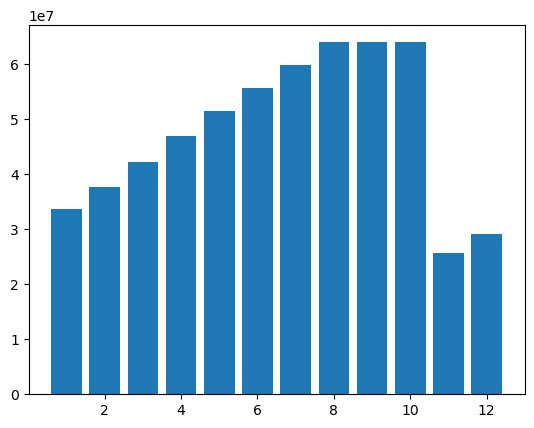

In [36]:
query="""select years,months,payment,sum(payment)
over(order by years, months) cumalative_sale from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on payments.order_id = orders.order_id
group by years,months order by years,months) as a
"""
cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data, columns=["Year", "Month" , "Payment" , "Cumulative_Sales"])
plt.bar(df["Month"], df["Cumulative_Sales"])
plt.show()

 # Calculate year by year growth rate of Total Sales

In [38]:
query="""with a as (select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on payments.order_id = orders.order_id
group by years order by years)
select years, (payment-lag(payment,1) over(order by years))/lag(payment,1) over(order by years)*100 from a
"""
cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data, columns=["Year", "Payment"])
df

,Year,Payment
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# Calcualte retention rate of Customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase 

In [40]:
query="""with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id= orders.customer_id
group by customers.customer_id),
b as(select a.customer_id, count(distinct(orders.order_purchase_timestamp)) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < date_add(first_order, interval 6 month)
group by a.customer_id)

select 100 * count(distinct a.customer_id)/count(distinct b.customer_id)
from a  left join b
on 
a.customer_id=b.customer_id;
"""
cur.execute(query)
data= cur.fetchall()
data

[(None,)]

# Identify the top 3 customers who spent the most money in each year

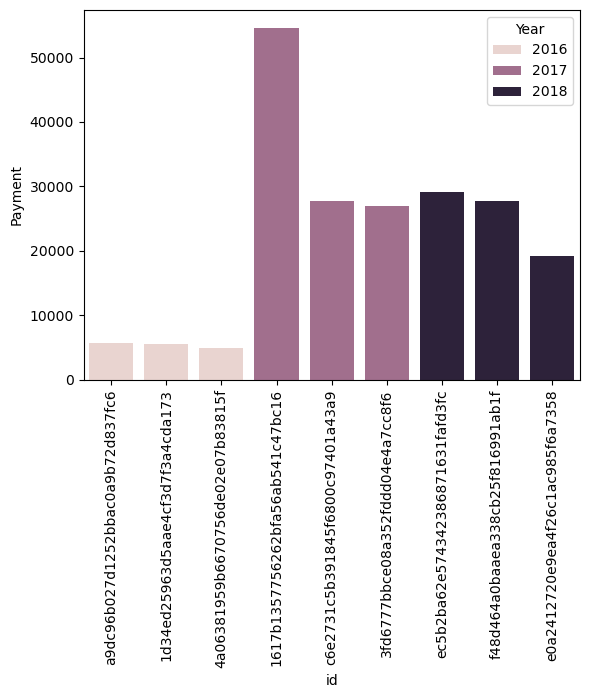

In [42]:
query="""select years,customer_id,payment,d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;
"""
cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data, columns=["Year", "id", "Payment", "Rank"])
sns.barplot(x="id", y="Payment", data=df, hue="Year")
plt.xticks(rotation=90)
plt.show()